# Prostate model

In [1]:
# Set up working environment for CoLoMoTo
import ginsim
import biolqm
import maboss
from colomoto_jupyter import tabulate
# for fixpoint table display
from itertools import combinations
# for iterating over sets
import matplotlib.pyplot as plt
# for modifying plots

FileNotFoundError: [Errno 2] No such file or directory: 'GINsim': 'GINsim'

## GINsim

Visualize the GINsim network

Note that most of the changes of the model were done in the files of MaBoSs directly. We need to find a way to update the GINsim model from the MaBoSS files

In [3]:
ginsim_WT = ginsim.load("PC.zginml")

NameError: name 'ginsim' is not defined

In [ ]:
ginsim.show(ginsim_WT)

Compute the fixpoints of the model 
(this may take some time)

In [ ]:
sols = ginsim.to_biolqm(ginsim_WT)
fps = biolqm.fixpoints(sols)
print(len(fps), "fixpoints")

In [ ]:
# Visualize the fixpoints only if necessary
# tabulate(fps)

## MaBoSS simulation of the wild type model

Run MaBoSS now. The files used are:
*PC.bnd* and *PC.cfg*

TO DO: Description of the prostate model here
Number of nodes + Number of edges + pathways described

PC_1.bnd has some rules modified from PC.bnd after a topological analysis using Cytoscape

Search for paths from EGF to Apoptosis because EGF seemed to increase apoptosis
1. Links (a) p53 -| CyclinB and (b) EGFR-|AMPK suppressed to avoid the positive paths from EGF to Apoptosis 
CyclinB = E2F1 & !p21
AMPK = (ATR | HIF1 | AMP_ATP | ATM) & !FGFR3
(no real justifications found for these rules)

2. In FADD, one input was missing: !MAP3K1_3 
FADD = (PTCH1 | TNFalpha) & !SHH & !MAP3K1_3

3. Metastasis was activated too easily. It always appeared with Proliferation. Some links were suppressed. 
The initial rule was: Metastasis =  (Migration & (AR_ERG | ERG | RUNX2)) 
The new rule is: Metastasis =  (Migration & AR_ERG) 

4. Migration was activated too easily 
The initial rule was: Migration = (((AKT & ERK) | (AKT & ETV1) | AR) & Invasion & EMT) 
The new rule is: Migration =  (((AKT & ERK) | (AKT & ETV1)) & Invasion & EMT)

In [16]:
# Set up the required files
bnd_file ="PC_1.bnd"
cfg_WT = "PC.cfg"

Load the model with randow initial conditions

In [3]:
# Load the Wild-Type model
WT = maboss.load(bnd_file, cfg_WT)

# modify the max_time if necessary
# select the variables considered to be internal (not appearing in the resulting csv file) 
# run the model for random initial conditions (defined in the cfg file)
WT_allinputs = maboss.copy_and_update_parameters(WT, {'max_time':50})
#for name in "Apoptosis RAS Invasion Migration Metastasis Proliferation Quiescence".split(' '):
#    WT_allinputs.network[name].is_internal = True

In [4]:
WT_allinputs.network.set_output(('Apoptosis','Metastasis', 'Proliferation', 'Quiescence'))
run_WT_allinputs = WT_allinputs.run()

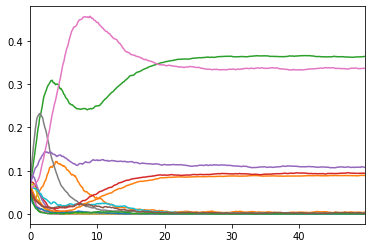

In [5]:
# Plot the results of the WT simulation
#run_WT_allinputs.get_states_probtraj().plot(legend=False)
run_WT_allinputs.plot_trajectory(legend=False)
# Note that the model state <nil> means that none of the external variables are ON. 
# figure = run_WT_allinputs.get_states_probtraj().plot()
# save_figure(figure, 'WT')

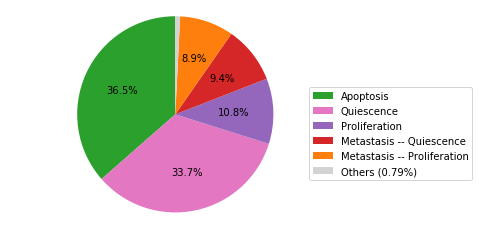

In [6]:
# Plot pie chart
run_WT_allinputs.plot_piechart()

# Simulations of different inputs

We now wish to explore the effect of some input activation on the final probabilities

Set all inputs at 0 to explore the effect of individual input

In [7]:
# Set conditions for simulations

# all nodes are random except for the initial conditions
WT_allinputs0 = maboss.copy_and_update_parameters(WT, {'max_time':50})
for name in "EGF FGF TGFb Nutrients Hypoxia MAX Acidosis Androgen fused_event TNFalpha SPOP Carcinogen".split(' '):
    WT_allinputs0.network.set_istate(name, [1,0]) 
    
# for all nodes of the network, the initial state is 0
# for n in WT.network:
#    WT_allinputs0.network.set_istate(n,[1,0])

In [8]:
# Run model
run_WT_allinputs0 = WT_allinputs0.run()

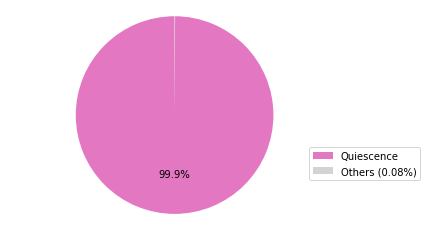

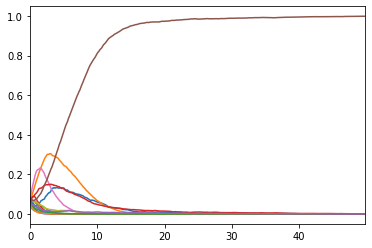

In [9]:
run_WT_allinputs0.plot_piechart()
run_WT_allinputs0.get_states_probtraj().plot(legend=False)

Single inputs ON 

In [12]:
# Model with EGFR ON at initial step
WT_input = WT_allinputs0.copy()

# set all the inputs to 0 and allow EGF only to be 1
# Modify the initial state by hand to test individual inputs
WT_input.network.set_istate('Nutrients', [0,1])

# WT_input.network.set_istate('EGF', [0,1])
# WT_input.network.set_istate('FGF', [0,1])
# To test combinations of inputs
# WT_input.network.set_istate(['EGF', 'FGF'],{(0, 0) : 0, (0, 1) : 1, (1, 0): 1, (1, 1): 1}) ?
# WT_input.network.set_istate(['EGF', 'FGF'],[{0, 1}, {0, 1}]) ? 

# Visualize only the outputs
WT_input.network.set_output(('Apoptosis','Quiescence','Proliferation', 'Metastasis', 'RAS', 'E2F1'))
run_WT_input = WT_input.run()

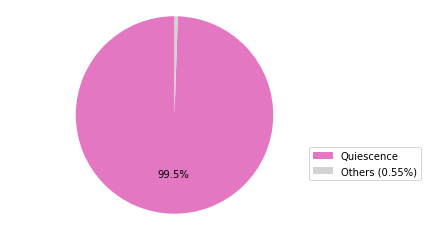

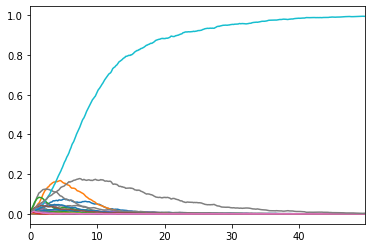

In [13]:
# Plot pie chart
run_WT_input.plot_piechart()

# Plot the trajectories
run_WT_input.get_states_probtraj().plot(legend=False)

## From MaBoSS to GINsim

Allow a section here where changes of the rules can be done directly from the notebook and saved in the bnd file. Then, all changes made in the bnd file can be saved in GINsim format

## Mutant simulations 

Simulate gain of function

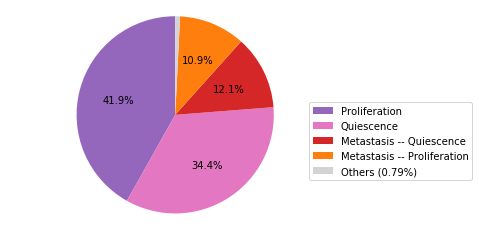

In [14]:
mut_AR_ON = WT.copy()
mut_AR_ON.mutate("AR", "ON")
mutres_AR_ON = mut_AR.run()
mutres_AR_ON.plot_piechart()

Simulate loss of function 

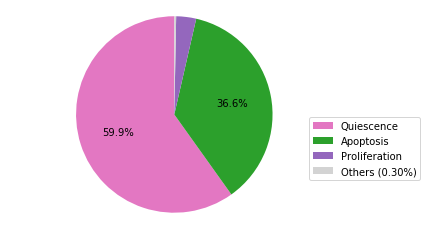

In [15]:
mut_AR_OFF = WT.copy()
mut_AR_OFF.mutate("AR", "OFF")
mutres_AR_OFF = mut_AR_OFF.run()
mutres_AR_OFF.plot_piechart()

## Automatic single and double mutant simulations

## Drug simulations

Simulate drug treatments here